In [1]:
import sys
import numpy as np
import pandas as pd

from Dissects.io import (load_NDskl, 
                         load_image,
                         load_skeleton,
                         save_skeleton,
                         save_fits
                        )
from Dissects.image import z_project
from Dissects.geometry import Skeleton
from Dissects.segmentation.seg_2D import (segmentation, 
                                          junction_around_cell)


%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# load image
image, metadata = load_image("../exemples/2d_images.tif")

In [4]:
# load ndskl file 
# cp, fil, point, specs = load_NDskl("../exemples/2d_images.NDskl.a.NDskl")
# create skeleton object
# skel = Skeleton(cp, fil, point, specs)


In [106]:
# Load skeleton
data = load_skeleton('2d_skeleton.hf5')
skel = Skeleton(data['critical_point'], data['filament'], data['point'])

/home/admin-suz/miniconda3/lib/python3.7/site-packages/Dissects-0.0.1-py3.7.egg/Dissects/geometry/skeleton.py:25: UserWarning: Has pixel can be half pixel from DisPerSE output,                   we take the integer part of xyz values. 
  we take the integer part of xyz values. ")


In [4]:
#Clean skeleton
skel.remove_lonely_cp()
skel.remove_free_filament()

/home/admin-suz/miniconda3/lib/python3.7/site-packages/Dissects-0.0.1-py3.7.egg/Dissects/geometry/skeleton.py:50: UserWarning: specs dictionnary is not updated, ncrit value is not updated.
  "specs dictionnary is not updated, ncrit value is not updated.")


<IPython.core.display.Javascript object>


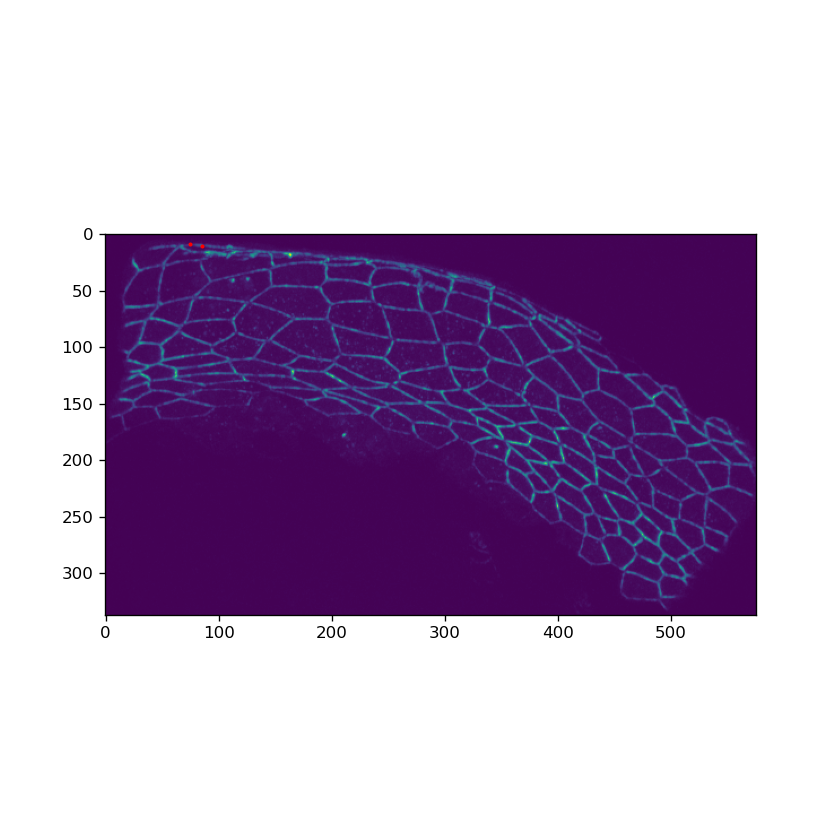

<IPython.core.display.Javascript object>


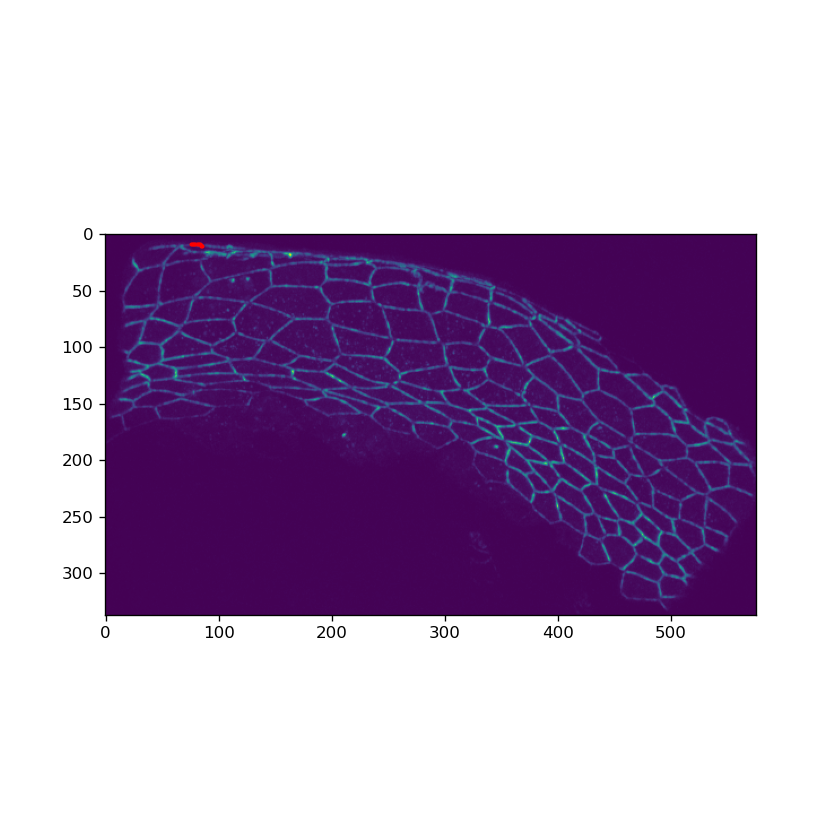

In [73]:
plt.figure(figsize=(7,7))
plt.imshow(image)
plt.scatter(skel.critical_point.loc[skel.filament.loc[0].cp1]['x'],
            skel.critical_point.loc[skel.filament.loc[0].cp1]['y'],
            color='red', s=2)
plt.scatter(skel.critical_point.loc[skel.filament.loc[0].cp2]['x'],
            skel.critical_point.loc[skel.filament.loc[0].cp2]['y'],
            color='red', s=2)

plt.figure(figsize=(7,7))
plt.imshow(image)
plt.scatter(skel.point[skel.point['filament']==0]['x'],
            skel.point[skel.point['filament']==0]['y'],
            color='red', s=2)
    
    

In [105]:
skel.specs = specs

<IPython.core.display.Javascript object>


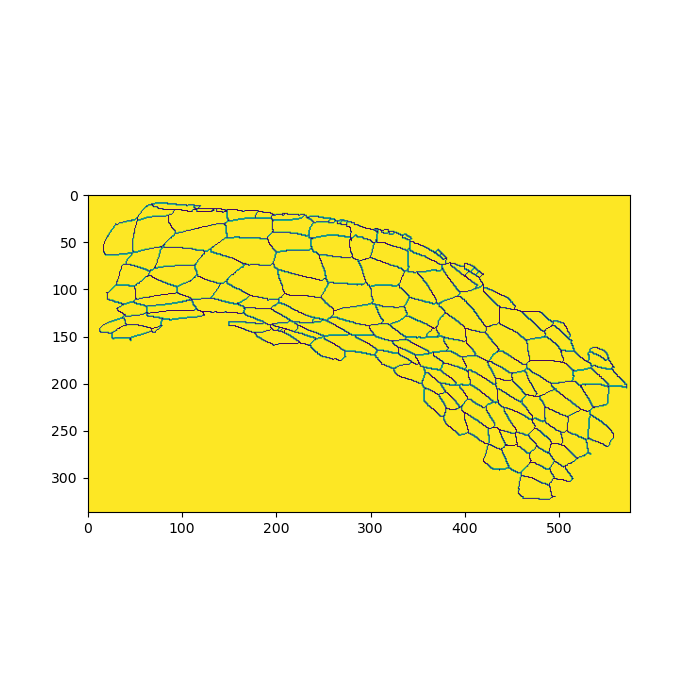

In [106]:
mask = skel.create_binary_image()
plt.figure(figsize=(7,7))
plt.imshow(mask)

<IPython.core.display.Javascript object>


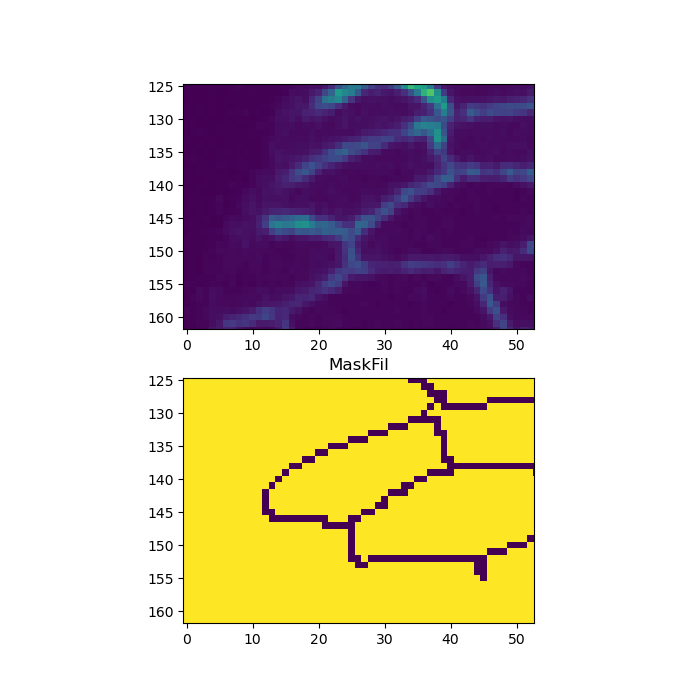

Text(0.5, 1.0, 'MaskFil')

In [8]:
plt.figure(figsize=(7,7))
ax1 = plt.subplot(2,1,1)
ax1.imshow(image,)
ax2 = plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
ax2.imshow(mask)
ax2.set_title('MaskFil')


<IPython.core.display.Javascript object>


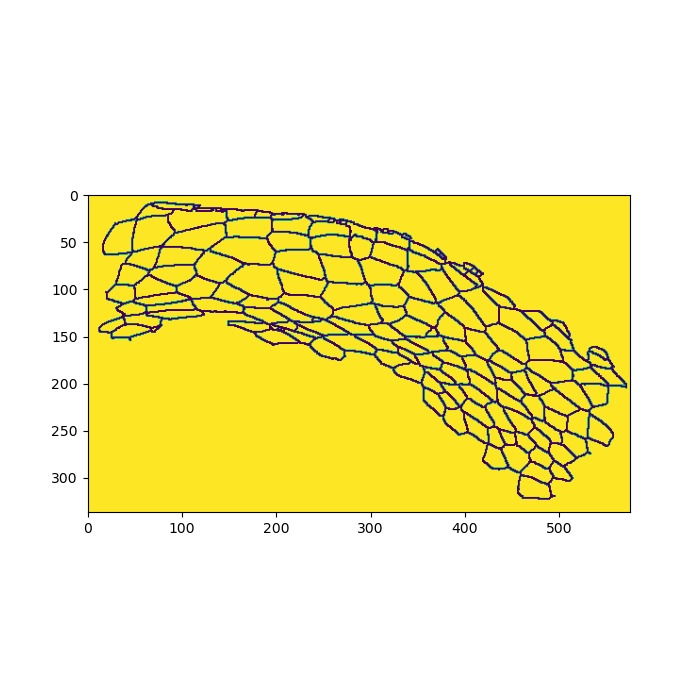

In [77]:
from Dissects.image import dilation
# elargissement
mask_dilation = dilation(mask, 2)
plt.figure(figsize=(7,7))
plt.imshow(mask_dilation)


<IPython.core.display.Javascript object>


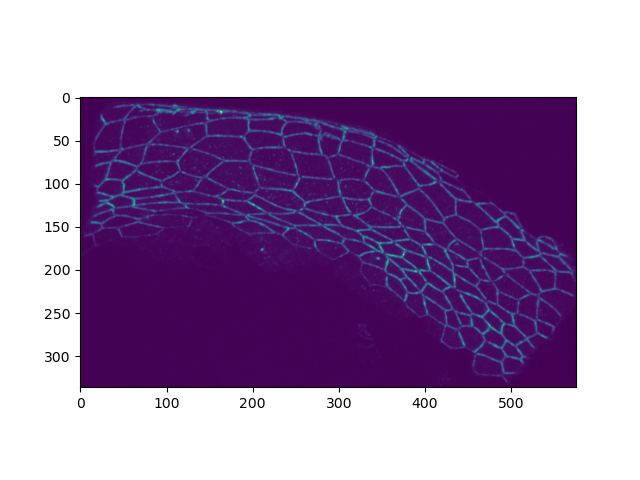

NameError: name 'mask_dilation' is not defined

In [75]:
fig, ax = plt.subplots()
ax.imshow(image)
y,x = np.where(mask_dilation==0)
ax.scatter(x,y, alpha=0.2, s=1, color='white')
plt.title('Masque Dilation + image original')

<IPython.core.display.Javascript object>


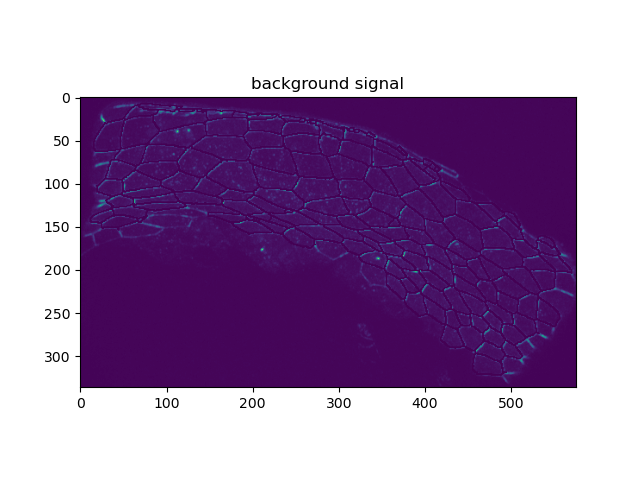

<IPython.core.display.Javascript object>


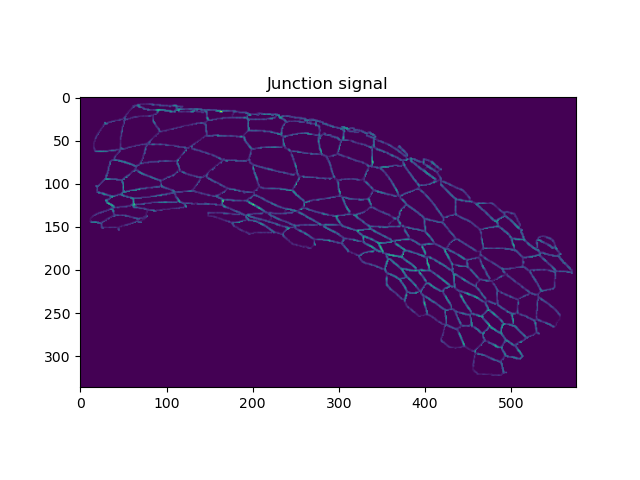

Text(0.5, 1.0, 'Junction signal')

In [127]:
# Bckground
plt.figure()
plt.imshow(mask_dilation * image)
plt.title('background signal')


#Junction
plt.figure()
plt.imshow((~mask_dilation.astype(bool))*image)
plt.title('Junction signal')


In [93]:
from Dissects.analysis import general_analysis
general_analysis(image, mask_dilation)

mean sig1 normalised= 0.12312735876179032
mean with 0 0.12312735876179032


# Passons à la segmentation


In [107]:
seg = segmentation(mask.astype(int))

<IPython.core.display.Javascript object>


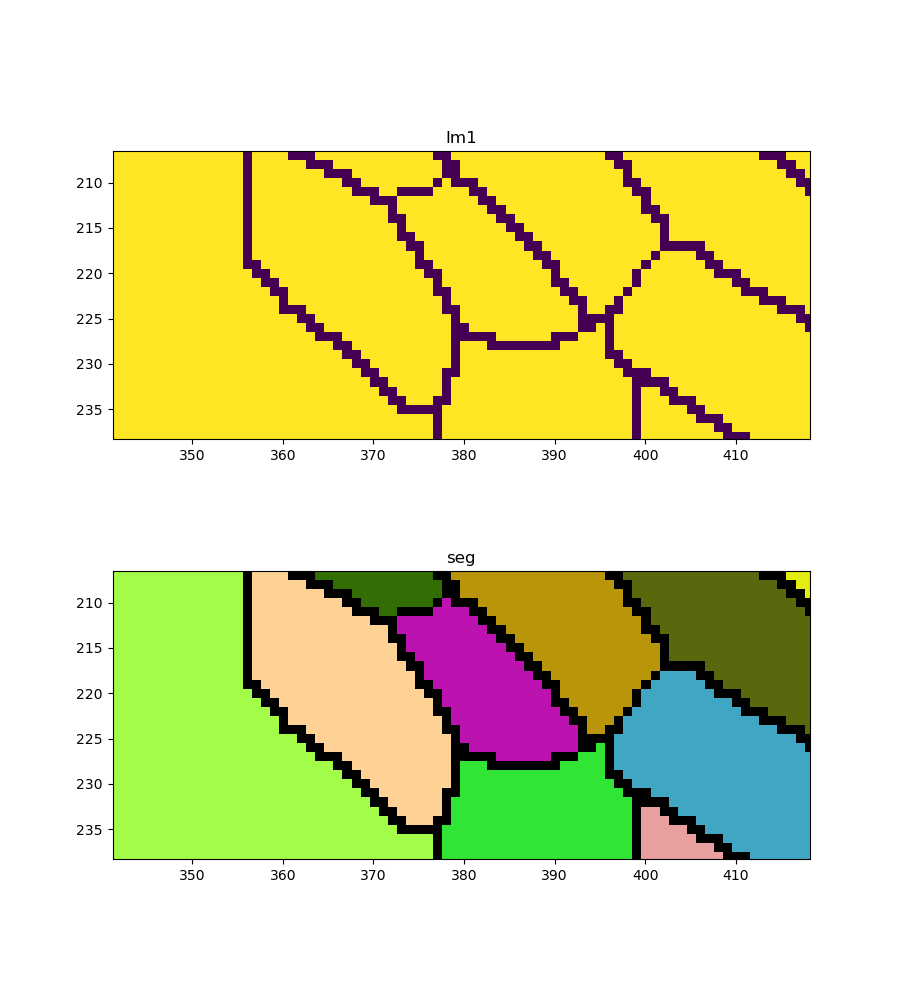

Text(0.5, 1.0, 'seg')

In [108]:
from matplotlib.colors import ListedColormap
rand = np.random.rand(256,3)
rand[0] = 0
cmap_rand = ListedColormap(rand)


plt.figure(figsize=(9,10))
ax1 = plt.subplot(2,1,1)
ax1.imshow(mask)
ax1.set_title('Im1')
ax2 = plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
ax2.imshow(seg, cmap=cmap_rand)
ax2.set_title('seg')

In [ ]:
junc_particular = junction_around_cell(mask.astype(int), seg, 9)

plt.figure()
plt.imshow(junc_particular)
plt.title('junc_particular')

# Ellipses

In [56]:
from astropy.modeling import models, fitting
from astropy.modeling.models import Ellipse2D
from astropy.coordinates import Angle
import warnings
%matplotlib inline
# fitting procedure
fit = fitting.SimplexLSQFitter() 
#fit = fitting.LevMarLSQFitter()

In [59]:
def Cell(seg,i):   
    segmentationi = np.zeros_like(seg)
    #for each cell get contour pixels
    segmentationi[np.where(seg == i)] = 1
    return segmentationi

y, x = np.mgrid[0:np.shape(seg)[0], 0:np.shape(seg)[1]] #grille 
init = np.zeros((len(np.unique(seg)[2:]),9))
#Dataframe_geo = pd.DataFrame(data=init,columns=['areaCell','perimeter','x_0','y_0','a','b','theta'])
Dataframe_geo = pd.DataFrame(data=init,columns=['perimeter','perimeter um','cellArea','cellArea um2',
                                                    'x_0','y_0','a','b','theta'])

for ind,i in enumerate(np.unique(seg)[2:]):
    print(i)
    JuncCellMaski = JuncCell(seg,MaskFil,i) 
    # enlarge through smoothing 2*KernelSize+1
    JuncCellMaski_conv = convolve(JuncCellMaski,Tophat2DKernel(KernelSize))
    JuncCellMaski_conv[np.where(JuncCellMaski_conv != 0)] = 1
        
    ### multiply this mask of filaments around cell i with pixels from Im
    #JuncCell_i=JuncCellMaski_conv*Im
        
    #compute the cell area and perimeter          
    Dataframe_geo ['perimeter'][ind] = len(np.where(JuncCellMaski == 1)[0])
    Dataframe_geo ['perimeter um'][ind] = len(np.where(JuncCellMaski == 1)[0]) / Conv
    Dataframe_geo ['cellArea'][ind] =  len(np.where(seg == i)[0])
    Dataframe_geo ['cellArea um2'][ind] =  len(np.where(seg == i)[0]) / Conv**2
   

    #Ellipse
    imCell = Cell(seg,i)
    # gaussian fit (to estimate x_0, y_0 and theta)
    gi = models.Gaussian2D(amplitude = 1., x_mean = np.where(imCell==1)[1][int(len(np.where(imCell == 1)[0]) / 2) + 1],
                           y_mean = np.where(imCell == 1)[0][int(len(np.where(imCell == 1)[0]) / 2) + 1], 
                           x_stddev=10, y_stddev=10, theta=0.0) #modèle initial
    g1 = fit(gi, x, y, imCell, maxiter=100000) #fit une gaussienne avec les parametres initiaux donnés
    # initial model: fais une ellipse fixe avec les parametres trouvés par le fit gaussien
    ei1 = models.Ellipse2D(amplitude=1., x_0=g1.x_mean, y_0=g1.y_mean, a=g1.x_stddev, b=g1.y_stddev, theta=g1.theta, fixed={'x_0': True, 'y_0':True, 'theta':True})
    #fitted model : on fit une ellipse et donc on change a et b 
    e1 = fit(ei1, x, y, imCell, maxiter=100000)
    e1.amplitude = 1
    z1 = e1(x, y)
    
    if e1.b.value > e1.a.value:
        e1.theta.value = e1.theta.value + np.pi/2 
        c = e1.a.value  
        e1.a.value = e1.b.value 
        e1.b.value = c

    Dataframe_geo['x_0'][ind] = e1.x_0.value
    Dataframe_geo['y_0'][ind] = e1.y_0.value
    Dataframe_geo['a'][ind] = e1.a.value
    Dataframe_geo['b'][ind] = e1.b.value
    Dataframe_geo['theta'][ind] = e1.theta.value
    
Dataframe_geo['e'] = np.sqrt( 1 - (Dataframe_geo['b']**2 / (Dataframe_geo['a']**2) ))
Dataframe_geo['an'] = Dataframe_geo['a'] / Dataframe_geo['b']
Dataframe_geo['a um'] = Dataframe_geo['a'] / Conv
Dataframe_geo['b um'] = Dataframe_geo['b'] / Conv 


2
3


KeyboardInterrupt: 

In [60]:
Dataframe_geo 

,perimeter,perimeter um,cellArea,cellArea um2,x_0,y_0,a,b,theta
0,107.0,19.605727,200.0,6.714727,90.821308,13.106894,22.98224,2.628174,0.081523
1,91.0,16.674030,280.0,9.400617,0.000000,0.000000,0.00000,0.000000,0.000000
2,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
3,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
4,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
5,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
6,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
7,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
8,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
9,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


In [95]:
from multiprocessing import Pool
import time

In [96]:
def Cell(seg,i):   
    segmentationi = np.zeros_like(seg)
    #for each cell get contour pixels
    segmentationi[np.where(seg == i)] = 1
    return segmentationi

def cellgeoi(inputs):
    ind,i,df = inputs
    print(i)

    JuncCellMaski = JuncCell(seg,MaskFil,i) 
    # enlarge through smoothing 2*KernelSize+1
    JuncCellMaski_conv = convolve(JuncCellMaski,Tophat2DKernel(KernelSize))
    JuncCellMaski_conv[np.where(JuncCellMaski_conv != 0)] = 1
        
    ### multiply this mask of filaments around cell i with pixels from Im
    #JuncCell_i=JuncCellMaski_conv*Im
        
    #compute the cell area and perimeter          
    df['perimeter'][ind] = len(np.where(JuncCellMaski == 1)[0])
    df['perimeter um'][ind] = len(np.where(JuncCellMaski == 1)[0]) / Conv
    df['cellArea'][ind] =  len(np.where(seg == i)[0])
    df['cellArea um'][ind] =  len(np.where(seg == i)[0]) / Conv**2
   

    #Ellipse
    imCell = Cell(seg,i)
    # gaussian fit (to estimate x_0, y_0 and theta)
    gi = models.Gaussian2D(amplitude = 1., x_mean = np.where(imCell==1)[1][int(len(np.where(imCell == 1)[0]) / 2) + 1],
                           y_mean = np.where(imCell == 1)[0][int(len(np.where(imCell == 1)[0]) / 2) + 1], 
                           x_stddev=10, y_stddev=10, theta=0.0) #modèle initial
    g1 = fit(gi, x, y, imCell, maxiter=100000) #fit une gaussienne avec les parametres initiaux donnés
    # initial model: fais une ellipse fixe avec les parametres trouvés par le fit gaussien
    ei1 = models.Ellipse2D(amplitude=1., x_0=g1.x_mean, y_0=g1.y_mean, a=g1.x_stddev, b=g1.y_stddev, theta=g1.theta, fixed={'x_0': True, 'y_0':True, 'theta':True})
    #fitted model : on fit une ellipse et donc on change a et b 
    e1 = fit(ei1, x, y, imCell, maxiter=100000)
    e1.amplitude = 1
    z1 = e1(x, y)
    
    if e1.b.value > e1.a.value:
        e1.theta.value = e1.theta.value + np.pi/2 
        c = e1.a.value  
        e1.a.value = e1.b.value 
        e1.b.value = c

    df['x_0'][ind] = e1.x_0.value
    df['y_0'][ind] = e1.y_0.value
    df['a'][ind] = e1.a.value
    df['b'][ind] = e1.b.value
    df['theta'][ind] = e1.theta.value
    
    return

start = time.time()
y, x = np.mgrid[0:np.shape(seg)[0], 0:np.shape(seg)[1]] #grille 
init = np.zeros((len(np.unique(seg)[2:]),9))
Dataframe_geo_para = pd.DataFrame(data=init,columns=['areaCell','perimeter','x_0','y_0','a','b','theta'])

all_inputs = zip(range(len(np.unique(seg)[2:])),np.unique(seg)[2:],repeat(Dataframe_geo_para))

pool = Pool()
CellGeo= pool.map_async(cellgeoi, all_inputs)
pool.close()
pool.join()
CellGeo.get()

Dataframe_geo_para['e'] = np.sqrt( 1 - (Dataframe_geo_para['b']**2 / (Dataframe_geo_para['a']**2) ))
Dataframe_geo_para['an'] = Dataframe_geo_para['a'] / Dataframe_geo_para['b']

end=time.time()

print('Cell Geo 4 cores ran in ',(end-start)/60.,' min')

ValueError: Shape of passed values is (125, 9), indices imply (125, 7)

In [114]:
Dataframe_geo.to_csv('Dataframe_geo.csv',index=False)

In [61]:
Dataframe_geo = pd.read_csv('/home/tmerle/Dataframe_geo.csv')

In [62]:
Dataframe_geo

,perimeter,perimeter um,cellArea,cellArea um2,x_0,y_0,a,b,theta,e,an,a um,b um
0,107.0,19.605727,200.0,6.714727,90.821308,13.106894,22.982240,2.628174,0.081523,0.993440,8.744564,4.211061,0.481563
1,91.0,16.674030,280.0,9.400617,69.703263,18.987758,18.717371,4.483674,-0.047456,0.970885,4.174561,3.429604,0.821549
2,171.0,31.332517,1004.0,33.707928,113.847206,26.570651,32.685212,9.241320,-0.079476,0.959197,3.536855,5.988947,1.693297
3,85.0,15.574643,248.0,8.326261,161.421728,21.440713,17.382391,4.245562,-0.045261,0.969714,4.094250,3.184994,0.777919
4,143.0,26.202046,1188.0,39.885477,67.557978,40.831704,22.540808,16.516873,-0.497257,0.680493,1.364714,4.130177,3.026405
5,121.0,22.170962,557.0,18.700514,217.021632,33.354150,22.914479,7.242139,-0.026520,0.948742,3.164049,4.198645,1.326985
6,127.0,23.270349,887.0,29.779813,33.916990,47.074628,21.030466,12.989458,2.208503,0.786453,1.619041,3.853435,2.380073
7,137.0,25.102660,904.0,30.350565,171.071195,35.685018,26.502506,10.251500,-0.037027,0.922158,2.585232,4.856083,1.878393
8,120.0,21.987731,541.0,18.163336,255.147575,37.128762,22.685317,6.828781,0.011131,0.953617,3.322016,4.156656,1.251245
9,111.0,20.338651,314.0,10.542121,291.346439,40.118827,17.619447,5.263020,0.382836,0.954345,3.347782,3.228431,0.964349


In [63]:
np.mean(Dataframe_geo['a um'])

3.586541683003724

In [64]:
from matplotlib.colors import LogNorm,PowerNorm

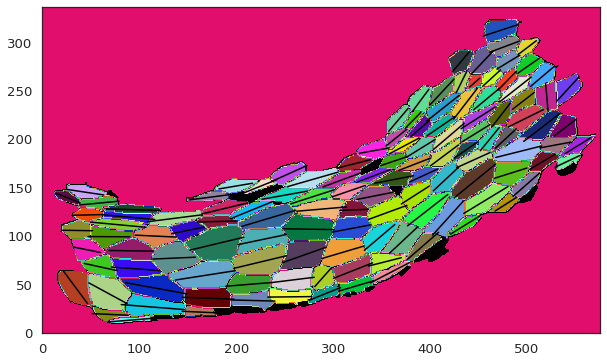

In [65]:
plt.figure(figsize=(10,10))
plt.imshow(seg,origin='lower',cmap=cmap_rand)
for i in range(len(Dataframe_geo)):
    startx = Dataframe_geo['x_0'][i] - Dataframe_geo['a'][i] * np.cos(Dataframe_geo['theta'][i])
    starty = Dataframe_geo['y_0'][i] - Dataframe_geo['a'][i] * np.sin(Dataframe_geo['theta'][i])
    endx = Dataframe_geo['x_0'][i] + Dataframe_geo['a'][i] * np.cos(Dataframe_geo['theta'][i])
    endy = Dataframe_geo['y_0'][i] + Dataframe_geo['a'][i] * np.sin(Dataframe_geo['theta'][i])
    
    
    plt.plot([startx, endx], [starty, endy], color='black')

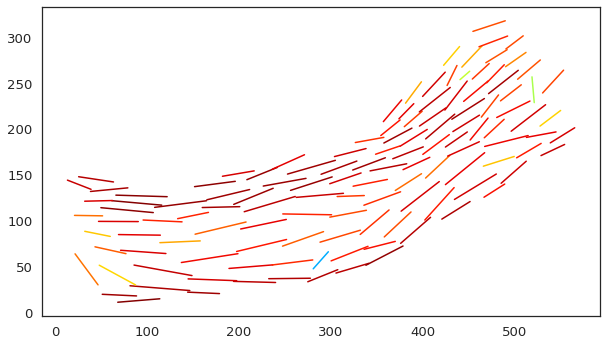

In [66]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
#plt.imshow(seg,origin='lower',cmap=cmap_rand)
for i in range(len(Dataframe_geo)):
    startx = Dataframe_geo['x_0'][i] - Dataframe_geo['a'][i] * np.cos(Dataframe_geo['theta'][i])
    starty = Dataframe_geo['y_0'][i] - Dataframe_geo['a'][i] * np.sin(Dataframe_geo['theta'][i])
    endx = Dataframe_geo['x_0'][i] + Dataframe_geo['a'][i] * np.cos(Dataframe_geo['theta'][i])
    endy = Dataframe_geo['y_0'][i] + Dataframe_geo['a'][i] * np.sin(Dataframe_geo['theta'][i])

    colori = plt.cm.jet(Dataframe_geo['e'][i]) # r is 0 to 1 inclusive
        
    plt.plot([startx, endx], [starty, endy], color=colori)
   
#plt.colorbar(Dataframe_geo_bis['e'])

In [67]:
from matplotlib.collections import LineCollection

def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

In [68]:
'''Fonction pour la jolie color bar'''

from mpl_toolkits import axes_grid1

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

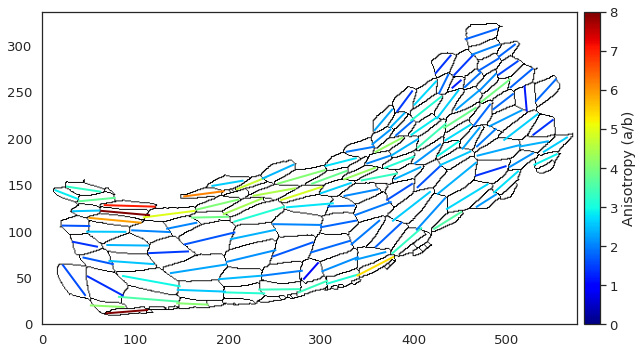

In [69]:
fig = plt.figure(figsize=(10,9))
ax.set_aspect('equal')
#plt.imshow(seg,origin='lower',cmap='viridis')
plt.imshow(InvMaskFil,origin='lower',cmap='gist_gray')
xs = []
ys = []
for i in range(len(Dataframe_geo)):
    startx = Dataframe_geo['x_0'][i] - Dataframe_geo['a'][i] * np.cos(Dataframe_geo['theta'][i])
    starty = Dataframe_geo['y_0'][i] - Dataframe_geo['a'][i] * np.sin(Dataframe_geo['theta'][i])
    endx = Dataframe_geo['x_0'][i] + Dataframe_geo['a'][i] * np.cos(Dataframe_geo['theta'][i])
    endy = Dataframe_geo['y_0'][i] + Dataframe_geo['a'][i] * np.sin(Dataframe_geo['theta'][i])
    
    xs.append([startx,endx])
    ys.append([starty,endy])
c = Dataframe_geo['an']
lc = multiline(xs, ys, c, cmap='jet', lw=2, clim = (0,8))
add_colorbar(lc, aspect=0.05, pad_fraction=0.5, label = 'Anisotropy (a/b)')

In [70]:
%matplotlib notebook

<IPython.core.display.Javascript object>


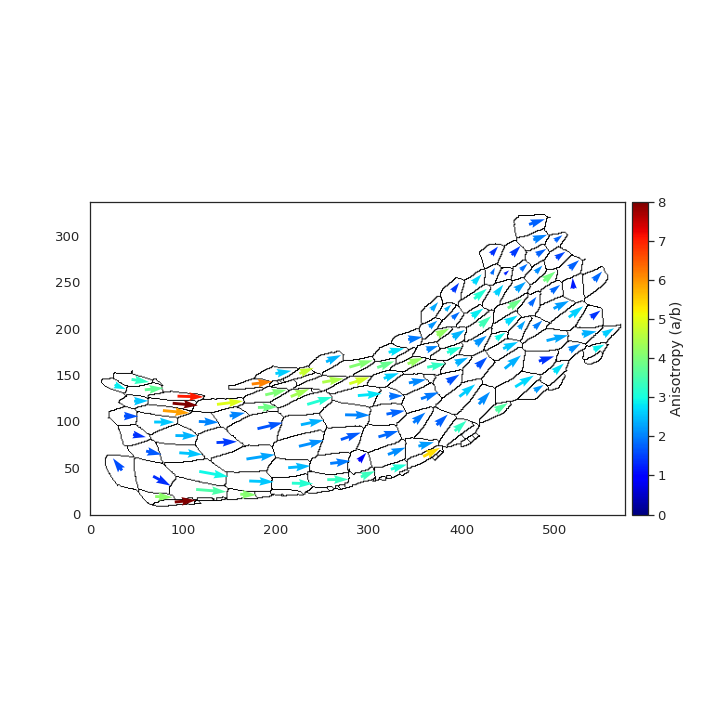

In [71]:
cmap1 = plt.cm.jet(np.arange(256))
cmap1[0] = [1., 1., 1., 1.]
cmap1 = ListedColormap(cmap1, name='myColorM', N=cmap1.shape[0])



fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(InvMaskFil,origin='lower',cmap='gist_gray')
q = ax.quiver(Dataframe_geo['x_0'], Dataframe_geo['y_0'], 
              0.5*Dataframe_geo['a'] * np.cos(Dataframe_geo['theta']), 
              0.5*Dataframe_geo['b'] * np.sin(Dataframe_geo['theta']), 
              Dataframe_geo['a']/Dataframe_geo['b'],
              units='xy' ,scale=0.5, 
              angles = Dataframe_geo['theta'] * 180 / np.pi,
              cmap='jet',
              clim = (0,8)
                                                    )
ax.set_aspect('equal')
#lc = multiline(xs, ys, c, cmap='jet', lw=2)
#axcb = fig.colorbar(lc)at's why it's called a la Turk.

add_colorbar(q, aspect=0.05, pad_fraction=0.5, label = 'Anisotropy (a/b)')


<IPython.core.display.Javascript object>


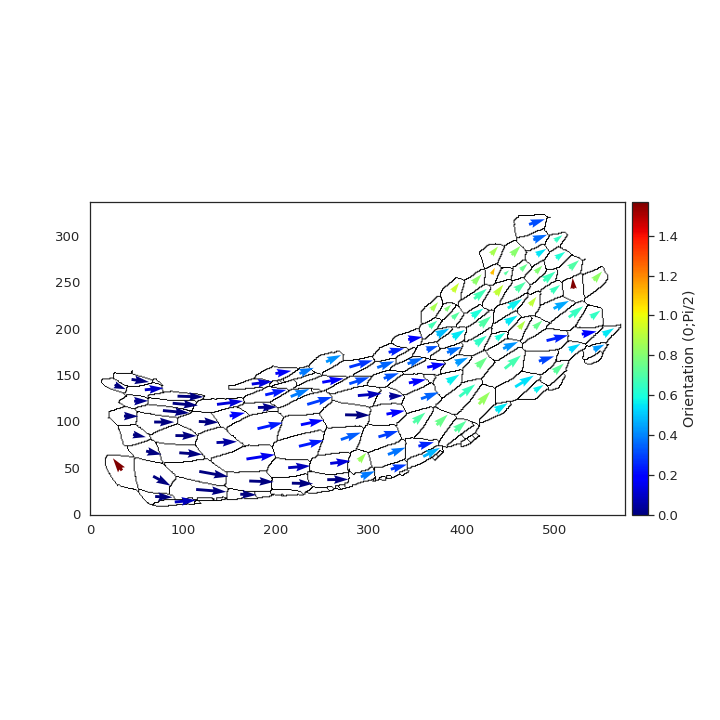

In [77]:
#Longueur de la flêche -> demi grand axe
#Couleur de la flêche -> Orientation (theta)


fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(InvMaskFil,origin='lower',cmap='gist_gray')
q = ax.quiver(Dataframe_geo['x_0'], Dataframe_geo['y_0'], 
              0.5*Dataframe_geo['a'] * np.cos(Dataframe_geo['theta']), 
              0.5*Dataframe_geo['b'] * np.sin(Dataframe_geo['theta']), 
              Dataframe_geo['theta'],
              units='xy' ,scale=0.5, 
              angles = Dataframe_geo['theta'] * 180 / np.pi,
              cmap='jet',
              clim = (0,np.pi/2)
                                                    )
ax.set_aspect('equal')
#lc = multiline(xs, ys, c, cmap='jet', lw=2)
#axcb = fig.colorbar(lc)at's why it's called a la Turk.

add_colorbar(q, aspect=0.05, pad_fraction=0.5, label = 'Orientation (0;Pi/2)')
